# **combatlearn**: Quick‑Start Demo
This notebook walks through the main **combatlearn** features:
vanilla ComBat (Johnson _et al._ 2007), covariate‑aware ComBat (Fortin _et al._ 2018), and CovBat (Chen _et al._ 2022).

```bash
# If you haven't installed the package yet, run this:
git clone https://github.com/EttoreRocchi/combatlearn.git
cd combatlearn
pip install .
pytest -q # optional, to run tests
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from combatlearn import ComBat

plt.rcParams['figure.dpi'] = 120


In [2]:
def plot_pca(X, labels, title):
    pca = PCA(n_components=2)
    pts = pca.fit_transform(X)
    fig = plt.figure(dpi=150)
    for b in np.unique(labels):
        idx = labels == b
        plt.scatter(pts[idx, 0], pts[idx, 1], label=f"batch {b}")
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()


## Original data

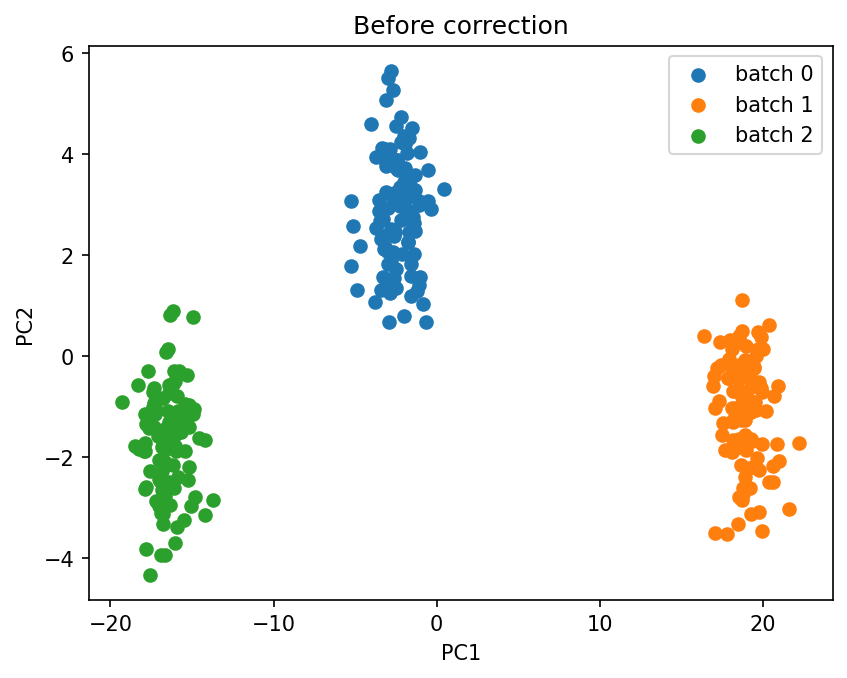

In [3]:
# Reproducibility
rng = np.random.default_rng(42)

n_samples, n_features, n_batches = 300, 50, 3
true_signal = rng.standard_normal((n_samples, n_features))

# Inject batch‑specific mean shifts
batch_effects = rng.normal(
    loc=np.array([0, 3, -2])[:, None],  # shape (3,1) for broadcasting
    scale=0.5,
    size=(n_batches, n_features)
)

batches = np.repeat(np.arange(n_batches), n_samples // n_batches)
X = true_signal.copy()

for b in range(n_batches):
    X[batches == b] += batch_effects[b]

X = pd.DataFrame(X, columns=[f"gene_{i+1}" for i in range(n_features)])
batch_labels = pd.Series(batches.astype(str), name='batch')

plot_pca(X.values, batch_labels.values, title='Before correction')

In [4]:
# Simulate a categorical (sex) and continuous (age) covariate
sex = pd.Series(rng.choice(['M', 'F'], size=n_samples), name='sex')
age = pd.Series(rng.uniform(20, 60, size=n_samples), name='age')

## The three methods

### Johnson method

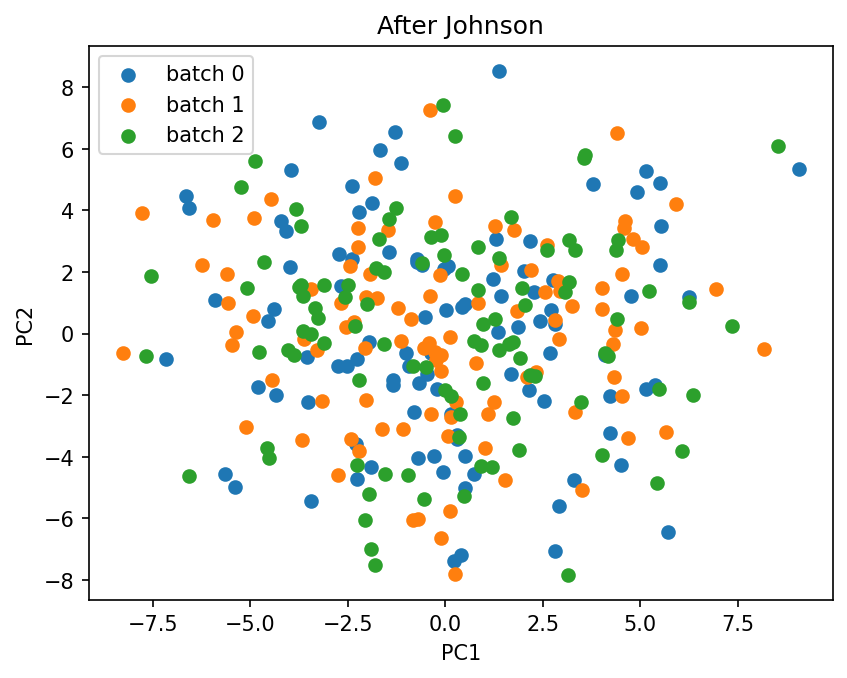

In [5]:
combat_johnson = ComBat(batch=batch_labels, method='johnson')
X_johnson = combat_johnson.fit_transform(X)

plot_pca(X_johnson.values, batch_labels.values, title='After Johnson')

Johnson's method ignores the covariates

In [6]:
combat_johnson_wc = ComBat(
    batch=batch_labels,
    discrete_covariates=sex,
    continuous_covariates=age,
    method='johnson',
)
X_johnson_wc = combat_johnson_wc.fit_transform(X)

print("Are all values equal?", np.allclose(X_johnson, X_johnson_wc))

Are all values equal? True


/home/ettorerocchi/combatlearn/src/combatlearn/combat.py:116: UserWarning: Covariates are ignored when using method='johnson'.
  warnings.warn(


### Fortin method

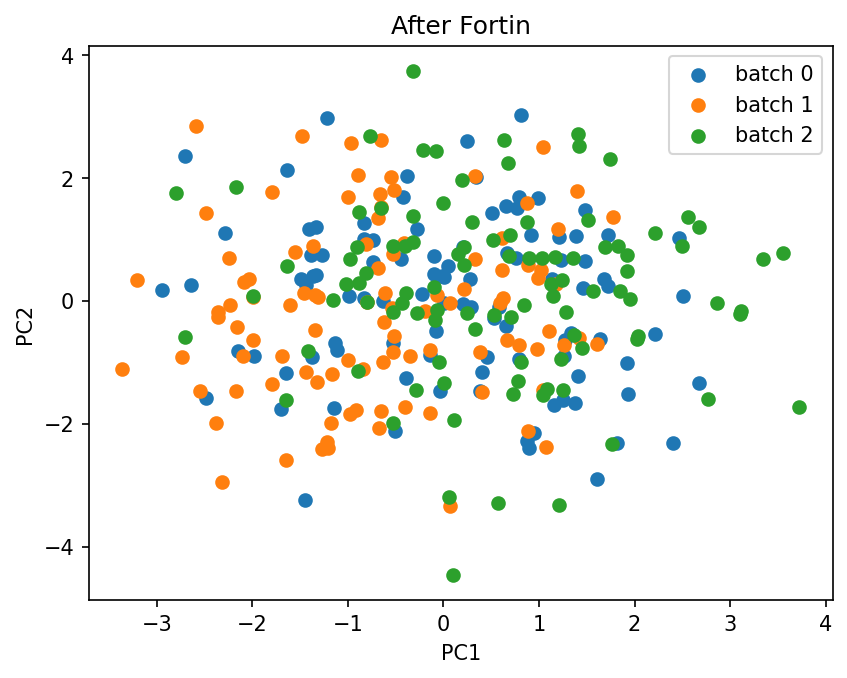

In [7]:
combat_fortin = ComBat(
    batch=batch_labels,
    discrete_covariates=sex,
    continuous_covariates=age,
    method='fortin'
)
X_fortin = combat_fortin.fit_transform(X)

plot_pca(X_fortin.values, batch_labels.values, title='After Fortin')

### Chen method

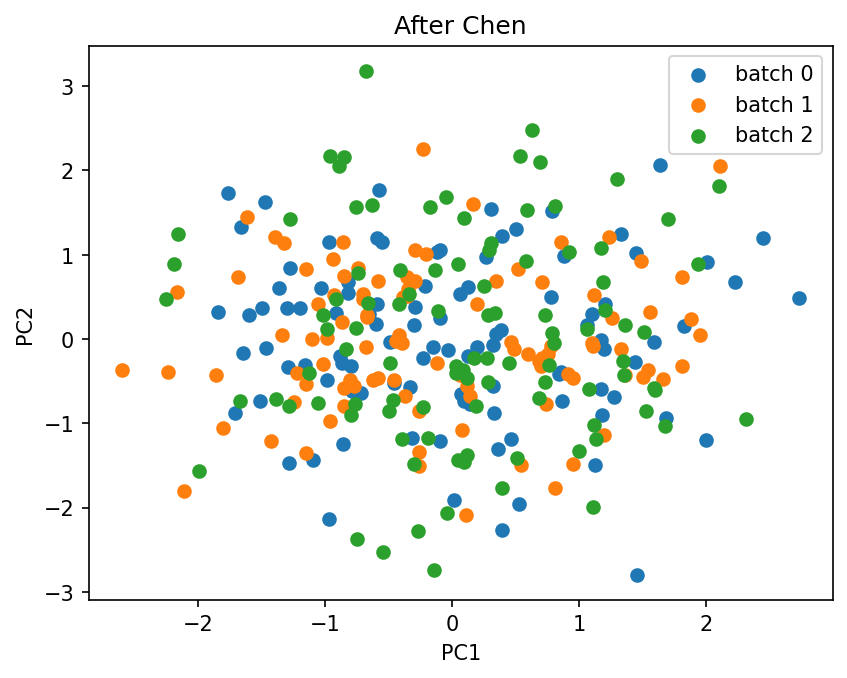

In [8]:
combat_chen = ComBat(
    batch=batch_labels,
    discrete_covariates=sex,
    continuous_covariates=age,
    method='chen',
    covbat_cov_thresh=0.95
)
X_chen = combat_chen.fit_transform(X)

plot_pca(X_chen.values, batch_labels.values, title='After Chen')

## Use of ComBat within a scikit-learn `Pipeline`

In [9]:
# Example: classification with a batch‑aware preprocessing pipeline
# (Here we create a toy binary label correlated with the true signal.)
y = (true_signal[:, 0] > 0).astype(int)

pipe = Pipeline([
    ('combat', ComBat(batch=batch_labels, method='johnson')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, X, y, cv=5)
print(f'Cross‑validated accuracy: {scores.mean():.3f} ± {scores.std():.3f}')

Cross‑validated accuracy: 0.907 ± 0.049
